In [1]:
# Loading libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm import tqdm

%matplotlib inline

## Data engineering

In [2]:
# let's import the vst-transformed count matrix (rows = samples, col = genes; last col = label)
lusc_data = pd.read_csv("./datasets/LUSC_geneReadCount_VST.csv")

In [3]:
lusc_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 551 entries, TCGA-94-7943-01A-11R-2187-07 to TCGA-51-4079-01A-01R-1100-07
Columns: 39753 entries, ENSG00000000003 to label
dtypes: float64(39752), object(1)
memory usage: 167.1+ MB


In [4]:
lusc_data.describe()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281849,ENSG00000281852,ENSG00000281880,ENSG00000281883,ENSG00000281896,ENSG00000281903,ENSG00000281904,ENSG00000281909,ENSG00000281912,ENSG00000281920
count,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,...,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000
mean,11.506768,3.210376,11.134674,9.733453,9.366600,9.736418,11.722034,11.641264,12.855367,11.043012,...,4.041995,4.042448,3.120010,3.606434,5.596421,4.555536,2.958657,3.082710,6.137523,4.073239
std,0.787590,0.489220,0.571272,0.434617,0.852139,1.322106,1.258561,0.614512,1.675005,0.487124,...,0.453254,0.880900,0.491202,0.442423,0.718426,0.651652,0.251155,0.318855,0.801420,0.684128
min,7.633507,2.867519,9.681449,8.687156,6.778143,6.532816,7.149722,9.207351,7.908137,9.835914,...,2.867519,2.867519,2.867519,2.867519,2.867519,2.867519,2.867519,2.867519,4.286747,2.867519
25%,11.028481,2.867519,10.740382,9.414906,8.960434,8.812821,10.870713,11.260034,11.560327,10.676899,...,3.767203,3.494788,2.867519,3.377046,5.174235,4.145110,2.867519,2.867519,5.601021,3.640888
50%,11.528563,2.867519,11.121858,9.711340,9.450394,9.633702,11.892007,11.657195,12.795053,11.006232,...,4.053541,3.864506,2.867519,3.636971,5.694652,4.508810,2.867519,2.867519,6.058458,3.970914
75%,11.998324,3.480934,11.516073,9.988039,9.921684,10.525566,12.618282,12.009649,14.104870,11.355443,...,4.298340,4.426093,3.352355,3.874470,6.071015,4.917957,2.867519,3.383177,6.563879,4.382519
max,15.404360,7.775136,13.403787,11.144561,11.439552,13.296483,14.531509,13.998175,17.055902,12.420048,...,5.662153,7.031399,6.139507,4.837585,7.661138,8.614201,5.295860,4.613722,9.488109,7.189747


In [5]:
lusc_data.head(n = 2)

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281852,ENSG00000281880,ENSG00000281883,ENSG00000281896,ENSG00000281903,ENSG00000281904,ENSG00000281909,ENSG00000281912,ENSG00000281920,label
TCGA-94-7943-01A-11R-2187-07,12.598295,3.347690,11.399091,9.710489,9.840727,9.545426,10.041732,12.644989,14.885584,11.249983,...,3.815171,2.867519,4.105474,6.292337,4.185603,2.867519,2.867519,5.871927,3.815171,TP
TCGA-68-8251-01A-11R-2296-07,11.612011,2.867519,10.177441,9.713037,10.129734,9.244418,11.915565,11.611566,11.623539,11.601289,...,3.601768,2.867519,3.762122,5.592759,4.582716,2.867519,3.601768,5.733117,3.601768,TP


Variables measured at differnet scales do not contribute equally to model fitting and might introduce a bias. One way to deal with it is feature-wise standarisation, i.e. mean = 0, and SD = 1 prior to model fitting.

In [6]:
# let's use `StandardScaler()` to z-score normalise each feature (column) individually.
lusc_data_zstd = pd.DataFrame(data    = StandardScaler().fit_transform(lusc_data.iloc[:, :-1]), 
                              index   = lusc_data.index,
                              columns = list(lusc_data.columns[:-1])).join(lusc_data['label']) # or lusc_data.iloc[:,-1:]

In [7]:
lusc_data_zstd

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281852,ENSG00000281880,ENSG00000281883,ENSG00000281896,ENSG00000281903,ENSG00000281904,ENSG00000281909,ENSG00000281912,ENSG00000281920,label
TCGA-94-7943-01A-11R-2187-07,1.387167,0.280933,0.463278,-0.052884,0.556902,-0.144592,-1.336311,1.634854,1.213168,0.425269,...,-0.258239,-0.514495,1.128994,0.969548,-0.568202,-0.363209,-0.675500,-0.331707,-0.377564,TP
TCGA-68-8251-01A-11R-2296-07,0.133749,-0.701462,-1.677140,-0.047016,0.896366,-0.372472,0.153912,-0.048371,-0.736086,1.147107,...,-0.500715,-0.514495,0.352218,-0.005102,0.041746,-0.363209,1.629362,-0.505070,-0.689782,TP
TCGA-33-A5GW-01A-11R-A27Q-07,0.922162,-0.701462,0.262537,-0.288630,-1.260078,-1.436069,-0.087827,0.849636,1.936794,0.567085,...,-1.334994,-0.514495,0.540015,-1.640591,0.645742,-0.363209,1.118610,0.151236,0.223405,TP
TCGA-85-8070-01A-11R-2247-07,-0.402538,-0.701462,0.795444,-1.087061,-0.631129,-1.827261,-2.529633,-1.213286,1.061201,-1.676591,...,-0.611750,-0.514495,0.348981,0.828542,-0.925190,-0.363209,-0.675500,0.864582,1.002522,TP
TCGA-85-8479-01A-11R-2326-07,-0.899380,-0.701462,-0.202639,0.652839,-0.306201,-0.964366,-0.960068,-1.286675,-0.276823,-1.109783,...,-1.334994,-0.514495,-0.415251,-0.719472,-0.562135,-0.363209,1.067832,0.642498,0.170172,TP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-21-1071-01A-01R-0692-07,-0.186548,-0.701462,1.227076,0.613010,0.866484,0.080287,0.662952,1.202308,1.157109,0.168546,...,-0.307512,-0.514495,-0.477767,0.148201,0.164770,-0.363209,0.981090,-0.112853,0.078701,TP
TCGA-33-AASD-01A-11R-A405-07,-1.056061,0.360107,0.330419,-0.522734,-0.081755,-1.556247,-1.233420,-0.510096,-0.414378,0.219674,...,-1.334994,0.972890,1.714926,0.208889,0.944840,-0.363209,1.615842,0.350967,2.160871,TP
TCGA-39-5029-01A-01R-1443-07,0.785722,0.320241,0.699639,-1.605893,-0.835948,0.049358,0.494847,0.546433,0.181647,-0.993850,...,-0.536453,-0.514495,-1.671674,-1.595338,-0.263715,-0.363209,-0.675500,-0.659077,-1.033400,TP
TCGA-MF-A522-01A-11R-A262-07,-0.929442,-0.701462,1.439745,1.890333,1.335930,-0.890828,-1.975320,-0.066189,1.630956,0.372686,...,-1.334994,-0.514495,1.291864,0.535048,-0.166069,-0.363209,-0.675500,-0.428256,-0.632710,TP


In [8]:
lusc_data_zstd.describe()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281849,ENSG00000281852,ENSG00000281880,ENSG00000281883,ENSG00000281896,ENSG00000281903,ENSG00000281904,ENSG00000281909,ENSG00000281912,ENSG00000281920
count,5.510000e+02,5.510000e+02,5.510000e+02,5.510000e+02,5.510000e+02,5.510000e+02,5.510000e+02,5.510000e+02,5.510000e+02,5.510000e+02,...,5.510000e+02,5.510000e+02,5.510000e+02,5.510000e+02,5.510000e+02,5.510000e+02,5.510000e+02,5.510000e+02,5.510000e+02,5.510000e+02
mean,8.736710e-16,-6.770144e-17,-1.109014e-15,5.125966e-16,6.286562e-16,-9.091336e-16,9.349247e-17,1.147701e-15,9.929545e-16,2.385670e-15,...,-2.018148e-15,2.901490e-16,1.966566e-16,-1.096119e-16,-1.081611e-15,-1.047760e-15,-4.964772e-16,-1.112238e-15,1.047760e-17,-1.096119e-16
std,1.000909e+00,1.000909e+00,1.000909e+00,1.000909e+00,1.000909e+00,1.000909e+00,1.000909e+00,1.000909e+00,1.000909e+00,1.000909e+00,...,1.000909e+00,1.000909e+00,1.000909e+00,1.000909e+00,1.000909e+00,1.000909e+00,1.000909e+00,1.000909e+00,1.000909e+00,1.000909e+00
min,-4.922332e+00,-7.014620e-01,-2.546152e+00,-2.409590e+00,-3.040358e+00,-2.425308e+00,-3.636268e+00,-3.964324e+00,-2.956246e+00,-2.480261e+00,...,-2.593567e+00,-1.334994e+00,-5.144951e-01,-1.671674e+00,-3.801897e+00,-2.592721e+00,-3.632086e-01,-6.754996e-01,-2.311469e+00,-1.764021e+00
25%,-6.078305e-01,-7.014620e-01,-6.908266e-01,-7.336037e-01,-4.770755e-01,-6.992151e-01,-6.770386e-01,-6.209416e-01,-7.738590e-01,-7.522637e-01,...,-6.068156e-01,-6.222698e-01,-5.144951e-01,-5.189528e-01,-5.881877e-01,-6.303969e-01,-3.632086e-01,-6.754996e-01,-6.700473e-01,-6.325474e-01
50%,2.769857e-02,-7.014620e-01,-2.245360e-02,-5.092558e-02,9.842377e-02,-7.776206e-02,1.351759e-01,2.594900e-02,-3.604103e-02,-7.557437e-02,...,2.549700e-02,-2.021833e-01,-5.144951e-01,6.908402e-02,1.368545e-01,-7.176900e-02,-3.632086e-01,-6.754996e-01,-9.874532e-02,-1.497056e-01
75%,6.246947e-01,5.535410e-01,6.682395e-01,5.863037e-01,6.519935e-01,5.974298e-01,7.127681e-01,6.000212e-01,7.466476e-01,6.419595e-01,...,5.660800e-01,4.359102e-01,4.734439e-01,6.063876e-01,6.612031e-01,5.566624e-01,-3.632086e-01,9.431874e-01,5.324852e-01,4.524901e-01
max,4.953254e+00,9.339160e+00,3.975648e+00,3.249741e+00,2.434855e+00,2.695170e+00,2.234319e+00,3.838905e+00,2.510054e+00,2.829435e+00,...,3.577755e+00,3.396147e+00,6.152748e+00,2.785274e+00,2.876557e+00,6.233929e+00,9.314274e+00,4.805955e+00,4.184611e+00,4.559588e+00


In addition, let's normalise the z-score standardised read count using the min-max approach, so that all values are in the range [0, 1]

In [9]:
# let's use `MinMaxScaler()` to Min-Max -> range[0,1] normalise each feature (column)
lusc_data_zstd_mm = pd.DataFrame(data    = MinMaxScaler().fit_transform(lusc_data_zstd.iloc[:, :-1]), 
                            index   = lusc_data_zstd.index,
                            columns = list(lusc_data_zstd.columns[:-1])).join(lusc_data_zstd['label']) # or lusc_data_zstd.iloc[:,-1:]

In [10]:
lusc_data_zstd_mm.head(n = 2)

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281852,ENSG00000281880,ENSG00000281883,ENSG00000281896,ENSG00000281903,ENSG00000281904,ENSG00000281909,ENSG00000281912,ENSG00000281920,label
TCGA-94-7943-01A-11R-2187-07,0.638899,0.097842,0.461442,0.416429,0.657008,0.445411,0.391776,0.717546,0.762749,0.547212,...,0.227589,0.0,0.628382,0.714454,0.229364,0.0,0.000000,0.304763,0.219251,TP
TCGA-68-8251-01A-11R-2296-07,0.511978,0.000000,0.133247,0.417465,0.719008,0.400907,0.645622,0.501837,0.406154,0.683159,...,0.176338,0.0,0.454098,0.568514,0.298467,0.0,0.420484,0.278075,0.169878,TP


In [11]:
lusc_data_zstd_mm.describe()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281849,ENSG00000281852,ENSG00000281880,ENSG00000281883,ENSG00000281896,ENSG00000281903,ENSG00000281904,ENSG00000281909,ENSG00000281912,ENSG00000281920
count,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,...,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000
mean,0.498434,0.069862,0.390406,0.425773,0.555295,0.473649,0.619405,0.508036,0.540813,0.467119,...,0.420261,0.282172,0.077168,0.375071,0.569278,0.293738,0.037531,0.123234,0.355825,0.278958
std,0.101352,0.099686,0.153471,0.176860,0.182807,0.195472,0.170496,0.128269,0.183105,0.188506,...,0.162187,0.211558,0.150123,0.224573,0.149871,0.113396,0.103427,0.182599,0.154079,0.158281
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.436886,0.000000,0.284481,0.296146,0.468161,0.337096,0.504077,0.428461,0.399244,0.325442,...,0.321933,0.150645,0.000000,0.258635,0.481206,0.222318,0.000000,0.000000,0.252679,0.178928
50%,0.501239,0.000000,0.386963,0.416774,0.573271,0.458462,0.642430,0.511362,0.534220,0.452886,...,0.424393,0.239437,0.000000,0.390572,0.589770,0.285607,0.000000,0.000000,0.340624,0.255284
75%,0.561691,0.124993,0.492869,0.529372,0.674376,0.590323,0.740818,0.584930,0.677404,0.588022,...,0.511989,0.374308,0.148178,0.511126,0.668283,0.356804,0.000000,0.295302,0.437795,0.350514
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
# let's encode the labels
lusc_data_zstd_mm = lusc_data_zstd_mm.replace("NT", 0) # NT (nromal tissue) as 0
lusc_data_zstd_mm = lusc_data_zstd_mm.replace("TP", 1) # TP (primary tumour) as 1

In [13]:
# let's check the count of each label type
print(lusc_data_zstd_mm["label"].value_counts())

1    502
0     49
Name: label, dtype: int64


In [14]:
# let's construct the target vector
labels = np.array(lusc_data_zstd_mm['label'])
labels.shape

(551,)

In [15]:
# let's construct the feature matrix (by dropping the label column)
features = lusc_data_zstd_mm.drop('label', axis = 1)
features.shape

(551, 39752)

In [16]:
features.isnull().sum().sum()

0

In [17]:
# let's import the list of features (genes) along with the differential testing statitsics
dge = pd.read_csv("./datasets/dge.csv", header = 0)
print(dge.shape)
dge.head()

(39610, 8)


,ensembl_gene_id,hgnc_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000228295,LINC00392,128.0,10.686,0.682,15.665,2.620000e-55,6.910000e-54
1,ENSG00000214107,MAGEB1,15.0,10.215,1.005,10.165,2.830000e-24,2.060000e-23
2,ENSG00000224960,PPP4R3C,14.0,10.069,0.891,11.299,1.320000e-29,1.250000e-28
3,ENSG00000197172,MAGEA6,1080.0,9.822,0.511,19.234,1.920000e-82,1.160000e-80
4,ENSG00000221867,MAGEA3,1180.0,9.772,0.504,19.401,7.560000e-84,4.790000e-82


In [18]:
# let's filter significant genes (padj <= 0.01) and sort by log2FC
ranked_dge = dge[dge['padj'] <= 0.01].sort_values(by = 'log2FoldChange', ascending = False, key = abs)
ranked_dge

,ensembl_gene_id,hgnc_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000228295,LINC00392,128.0,10.686,0.682,15.665,2.620000e-55,6.910000e-54
1,ENSG00000214107,MAGEB1,15.0,10.215,1.005,10.165,2.830000e-24,2.060000e-23
2,ENSG00000224960,PPP4R3C,14.0,10.069,0.891,11.299,1.320000e-29,1.250000e-28
3,ENSG00000197172,MAGEA6,1080.0,9.822,0.511,19.234,1.920000e-82,1.160000e-80
4,ENSG00000221867,MAGEA3,1180.0,9.772,0.504,19.401,7.560000e-84,4.790000e-82
...,...,...,...,...,...,...,...,...
34970,ENSG00000136709,WDR33,3990.0,0.172,0.049,3.523,4.270000e-04,7.870000e-04
34991,ENSG00000102974,CTCF,3590.0,0.171,0.052,3.290,1.000000e-03,1.770000e-03
35120,ENSG00000161813,LARP4,3370.0,0.166,0.061,2.732,6.290000e-03,1.000000e-02
35437,ENSG00000182149,IST1,7100.0,-0.154,0.052,-2.949,3.190000e-03,5.280000e-03


In [19]:
# let's take the top n genes as features 
ranked_dge10   = ranked_dge.iloc[:10,:2]
ranked_dge20   = ranked_dge.iloc[:20,:2]
ranked_dge50   = ranked_dge.iloc[:50,:2]
ranked_dge100  = ranked_dge.iloc[:100,:2]
ranked_dge1000 = ranked_dge.iloc[:1000,:2]

In [20]:
ranked_dge10

,ensembl_gene_id,hgnc_symbol
0,ENSG00000228295,LINC00392
1,ENSG00000214107,MAGEB1
2,ENSG00000224960,PPP4R3C
3,ENSG00000197172,MAGEA6
4,ENSG00000221867,MAGEA3
5,ENSG00000128714,HOXD13
6,ENSG00000236956,NF1P8
7,ENSG00000132446,FTHL17
8,ENSG00000123584,MAGEA9
9,ENSG00000170516,COX7B2


In [21]:
# let's substitute the feature matrix using the ranked genes
features_dge10 = features.filter(ranked_dge10['ensembl_gene_id'])
# rename columns: Ensembl Ids -> RefSeq Ids
features_dge10.rename(columns = dict(zip(ranked_dge10['ensembl_gene_id'], ranked_dge10['hgnc_symbol'])), inplace= True)
features_dge10

,LINC00392,MAGEB1,PPP4R3C,MAGEA6,MAGEA3,HOXD13,NF1P8,FTHL17,MAGEA9,COX7B2
TCGA-94-7943-01A-11R-2187-07,0.000000,0.000000,0.067907,0.082330,0.209791,0.267373,0.000000,0.000000,0.000000,0.000000
TCGA-68-8251-01A-11R-2296-07,0.155906,0.000000,0.000000,0.089290,0.121509,0.844284,0.000000,0.840795,0.895832,0.000000
TCGA-33-A5GW-01A-11R-A27Q-07,0.066505,0.000000,0.206346,0.824120,0.630965,0.479416,0.000000,0.093708,0.000000,0.053852
TCGA-85-8070-01A-11R-2247-07,0.000000,0.068765,0.000000,0.792848,0.805096,0.429956,0.666486,0.074266,0.619046,0.356765
TCGA-85-8479-01A-11R-2326-07,0.064623,0.000000,0.000000,0.000000,0.047333,0.393815,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
TCGA-21-1071-01A-01R-0692-07,0.359505,0.000000,0.000000,0.750088,0.788005,0.059601,0.669583,0.000000,0.000000,0.190252
TCGA-33-AASD-01A-11R-A405-07,0.103492,0.000000,0.000000,0.741209,0.777079,0.844633,0.777910,0.165415,0.000000,0.141047
TCGA-39-5029-01A-01R-1443-07,0.421653,0.000000,0.099391,0.720999,0.735255,0.543536,0.235564,0.379284,0.000000,0.103241
TCGA-MF-A522-01A-11R-A262-07,0.223938,0.059418,0.000000,0.796156,0.421449,0.424643,0.447654,0.000000,0.000000,0.000000


## Model engineering

In [22]:
# let's split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_dge10, labels, test_size = .2, random_state = 2)

In [23]:
# let's check the shape of each set
(X_train.shape,
 y_train.shape,
 X_test.shape,
 y_test.shape)

((440, 10), (440,), (111, 10), (111,))

Let's use nested cross validation for model hyperparameter optimisation and model selection in order to avoid overfitting.

In [24]:
clf_list, valid_roc_list = ([], [])
selected_genes = set()

# let's define a function to split the data into train/validation sets using stratified Sampling (vs random sampling)
train_val_sss = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 1)

# split the data into train/validation sets
for train_idx, val_idx in tqdm(train_val_sss.split(X_train, y_train)):

    train_data, val_data     = X_train.iloc[train_idx], X_train.iloc[val_idx]
    train_target, val_target = y_train[train_idx], y_train[val_idx]
    
    # build a classifer (clf) using a logistic regression model with cross validation
    clf = LogisticRegressionCV(cv=5, scoring = "roc_auc", penalty="elasticnet", 
                               fit_intercept=True, solver="saga", Cs=10, 
                               n_jobs=3, max_iter=20000, random_state = 2,
                               class_weight='balanced',
                               l1_ratios = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1])

    # fit the model
    clf.fit(train_data, train_target)
    # store the classifers
    clf_list.append(clf)
    # print
    print ('Max auc_roc:', clf.scores_[1].mean(axis=0).max())

    # capture the top k feature based on the estimator model metrics (vs. p-value)
    selector = SelectFromModel(clf, prefit = True, threshold = None)
    # subset the training set using the selected features and store
    [selected_genes.add(x) for x in train_data.loc[:, selector.get_support()].columns.values]

    # use the model to predict the validation set
    y_pred_prob = clf.predict_proba(val_data)[:,1]
    # calcualte ROC on validation set
    valid_roc_list.append(roc_curve(val_target, y_pred_prob))


1it [00:05,  5.70s/it]

Max auc_roc: 0.9785641025641028


2it [00:10,  5.18s/it]

Max auc_roc: 0.9781538461538462


3it [00:14,  4.68s/it]

Max auc_roc: 0.9761025641025644


4it [00:19,  4.75s/it]

Max auc_roc: 0.9848205128205129


5it [00:23,  4.77s/it]

Max auc_roc: 0.9760000000000002


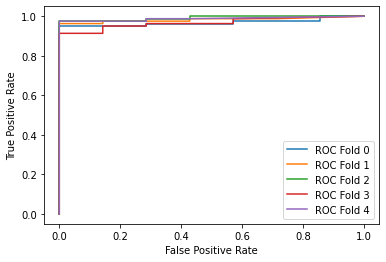

In [25]:
for i in range(len(valid_roc_list)):
    plt.plot(valid_roc_list[i][0],      # fpr
             valid_roc_list[i][1],      # tpr
             label = 'ROC Fold %s' %i)  # label
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()